In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [30]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# 데이터 살펴보기

In [31]:
sample = glob('/content/drive/MyDrive/GDSC 해커톤/DATASET/train/*')[0]

sample_image = cv2.imread(glob(sample+'/*.jpg')[0])
sample_json = json.load(open(glob(sample+'/*.json')[0], 'r'))

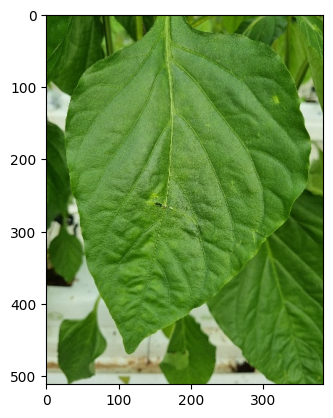

In [32]:
# image
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.show()

In [33]:
# json
sample_json

{'description': {'date': '20211103',
  'image': '35019.jpg',
  'task': 2,
  'width': 384,
  'time': '1542',
  'region': 0,
  'height': 512},
 'annotations': {'area': 3,
  'disease': 'b6',
  'grow': 13,
  'bbox': [{'x': 23.017291356646826,
    'h': 454.1083519345238,
    'y': 21.972985646081348,
    'w': 347.3824094742063}],
  'part': [{'x': 27.202605716765873,
    'h': 237.51751612103175,
    'y': 29.2973148406498,
    'id': 0,
    'w': 141.25489831349208},
   {'x': 95.2142314608135,
    'h': 161.1352306547619,
    'y': 265.7685081845238,
    'id': 1,
    'w': 83.70660497271825},
   {'x': 228.09847780257937,
    'h': 114.05025421626983,
    'y': 282.50982762896825,
    'id': 2,
    'w': 108.81859188988095},
   {'x': 310.7587425595238,
    'h': 21.972981770833332,
    'y': 107.7722671750992,
    'id': 3,
    'w': 13.602337549603174}],
  'risk': 1,
  'crop': 3}}

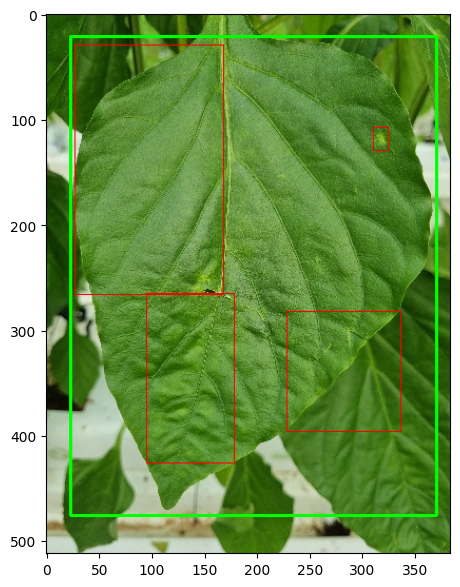

In [34]:
# visualize bbox
plt.figure(figsize=(7,7))
points = sample_json['annotations']['bbox'][0]
part_points = sample_json['annotations']['part']
img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

cv2.rectangle(
    img,
    (int(points['x']), int(points['y'])),
    (int((points['x']+points['w'])), int((points['y']+points['h']))),
    (0, 255, 0),
    2
)
for part_point in part_points:
    point = part_point
    cv2.rectangle(
        img,
        (int(point['x']), int(point['y'])),
        (int((point['x']+point['w'])), int((point['y']+point['h']))),
        (255, 0, 0),
        1
    )
plt.imshow(img)
plt.show()

# CustomDataset 제작

In [35]:
# 변수 설명 csv 파일 참조
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
risk = {'1':'초기','2':'중기','3':'말기'}

In [36]:
label_description = {}
for key, value in disease.items():
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
    for disease_code in value:
        for risk_code in risk:
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'
list(label_description.items())[:10]

[('1_00_0', '딸기_정상'),
 ('1_a1_1', '딸기_딸기잿빛곰팡이병_초기'),
 ('1_a1_2', '딸기_딸기잿빛곰팡이병_중기'),
 ('1_a1_3', '딸기_딸기잿빛곰팡이병_말기'),
 ('1_a2_1', '딸기_딸기흰가루병_초기'),
 ('1_a2_2', '딸기_딸기흰가루병_중기'),
 ('1_a2_3', '딸기_딸기흰가루병_말기'),
 ('1_b1_1', '딸기_냉해피해_초기'),
 ('1_b1_2', '딸기_냉해피해_중기'),
 ('1_b1_3', '딸기_냉해피해_말기')]

In [37]:
label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

In [39]:
label_decoder

{0: '1_00_0',
 1: '1_a1_1',
 2: '1_a1_2',
 3: '1_a1_3',
 4: '1_a2_1',
 5: '1_a2_2',
 6: '1_a2_3',
 7: '1_b1_1',
 8: '1_b1_2',
 9: '1_b1_3',
 10: '1_b6_1',
 11: '1_b6_2',
 12: '1_b6_3',
 13: '1_b7_1',
 14: '1_b7_2',
 15: '1_b7_3',
 16: '1_b8_1',
 17: '1_b8_2',
 18: '1_b8_3',
 19: '2_00_0',
 20: '2_a5_1',
 21: '2_a5_2',
 22: '2_a5_3',
 23: '2_a6_1',
 24: '2_a6_2',
 25: '2_a6_3',
 26: '2_b2_1',
 27: '2_b2_2',
 28: '2_b2_3',
 29: '2_b3_1',
 30: '2_b3_2',
 31: '2_b3_3',
 32: '2_b6_1',
 33: '2_b6_2',
 34: '2_b6_3',
 35: '2_b7_1',
 36: '2_b7_2',
 37: '2_b7_3',
 38: '2_b8_1',
 39: '2_b8_2',
 40: '2_b8_3',
 41: '3_00_0',
 42: '3_a9_1',
 43: '3_a9_2',
 44: '3_a9_3',
 45: '3_a10_1',
 46: '3_a10_2',
 47: '3_a10_3',
 48: '3_b3_1',
 49: '3_b3_2',
 50: '3_b3_3',
 51: '3_b6_1',
 52: '3_b6_2',
 53: '3_b6_3',
 54: '3_b7_1',
 55: '3_b7_2',
 56: '3_b7_3',
 57: '3_b8_1',
 58: '3_b8_2',
 59: '3_b8_3',
 60: '4_00_0',
 61: '4_a3_1',
 62: '4_a3_2',
 63: '4_a3_3',
 64: '4_a4_1',
 65: '4_a4_2',
 66: '4_a4_3',
 6

In [10]:
label_encoder

{'1_00_0': 0,
 '1_a1_1': 1,
 '1_a1_2': 2,
 '1_a1_3': 3,
 '1_a2_1': 4,
 '1_a2_2': 5,
 '1_a2_3': 6,
 '1_b1_1': 7,
 '1_b1_2': 8,
 '1_b1_3': 9,
 '1_b6_1': 10,
 '1_b6_2': 11,
 '1_b6_3': 12,
 '1_b7_1': 13,
 '1_b7_2': 14,
 '1_b7_3': 15,
 '1_b8_1': 16,
 '1_b8_2': 17,
 '1_b8_3': 18,
 '2_00_0': 19,
 '2_a5_1': 20,
 '2_a5_2': 21,
 '2_a5_3': 22,
 '2_a6_1': 23,
 '2_a6_2': 24,
 '2_a6_3': 25,
 '2_b2_1': 26,
 '2_b2_2': 27,
 '2_b2_3': 28,
 '2_b3_1': 29,
 '2_b3_2': 30,
 '2_b3_3': 31,
 '2_b6_1': 32,
 '2_b6_2': 33,
 '2_b6_3': 34,
 '2_b7_1': 35,
 '2_b7_2': 36,
 '2_b7_3': 37,
 '2_b8_1': 38,
 '2_b8_2': 39,
 '2_b8_3': 40,
 '3_00_0': 41,
 '3_a9_1': 42,
 '3_a9_2': 43,
 '3_a9_3': 44,
 '3_a10_1': 45,
 '3_a10_2': 46,
 '3_a10_3': 47,
 '3_b3_1': 48,
 '3_b3_2': 49,
 '3_b3_3': 50,
 '3_b6_1': 51,
 '3_b6_2': 52,
 '3_b6_3': 53,
 '3_b7_1': 54,
 '3_b7_2': 55,
 '3_b7_3': 56,
 '3_b8_1': 57,
 '3_b8_2': 58,
 '3_b8_3': 59,
 '4_00_0': 60,
 '4_a3_1': 61,
 '4_a3_2': 62,
 '4_a3_3': 63,
 '4_a4_1': 64,
 '4_a4_2': 65,
 '4_a4_3': 66,
 '

In [11]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train'):
        self.mode = mode
        self.files = files
        self.label_encoder = labels

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('/')[-1]
        image_path = f'{file}/{file_name}.jpg'

        if not os.path.exists(image_path):
            # 파일이 없는 경우, 0로 채워진 이미지 텐서를 반환
            img = np.full((3, 256, 256), 0, dtype=np.float32)  # 채널 3, 크기 256x256
            return {
                'img': torch.tensor(img, dtype=torch.float32),
                'label': torch.tensor(len(label_encoder), dtype=torch.long)  # 'label'도 -1로 설정
            }

        # 파일이 존재하는 경우, 정상 처리
        img = cv2.imread(image_path)
        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32) / 255
        img = np.transpose(img, (2, 0, 1))

        if self.mode == 'train':
            json_path = f'{file}/{file_name}.json'

            if not os.path.exists(json_path):
            # 파일이 없는 경우, 0로 채워진 이미지 텐서를 반환
                img = np.full((3, 256, 256), 0, dtype=np.float32)  # 채널 3, 크기 256x256
                return {
                    'img': torch.tensor(img, dtype=torch.float32),
                    'label': torch.tensor(len(label_encoder), dtype=torch.long)  # 'label'도 -1로 설정
                }

            with open(json_path, 'r') as f:
                json_file = json.load(f)


            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'

            return {
                'img': torch.tensor(img, dtype=torch.float32),
                'label': torch.tensor(self.label_encoder[label], dtype=torch.long)
            }
        else:
            return {
                'img': torch.tensor(img, dtype=torch.float32),
            }

In [12]:
device = torch.device("cuda:0")
batch_size = 256
class_n = len(label_encoder)+1
learning_rate = 1e-4
embedding_dim = 512
dropout_rate = 0.1
epochs = 10
vision_pretrain = True
save_path = '/content/drive/MyDrive/GDSC 해커톤/MODEL_SAVE/best_model.pt'

# 데이터셋 구성

In [13]:
train = sorted(glob('/content/drive/MyDrive/GDSC 해커톤/DATASET/train/*'))

labelsss = pd.read_csv('/content/drive/MyDrive/GDSC 해커톤/DATASET/train.csv')['label']
train, val = train_test_split(train, test_size=0.2, stratify=labelsss)

In [14]:
train_dataset = CustomDataset(train, label_encoder)
val_dataset = CustomDataset(val, label_encoder)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=0, shuffle=False)

# 모델

In [15]:
class CNN_Model(nn.Module):
    def __init__(self, class_n, rate=0.1):
        super(CNN_Model, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.dropout = nn.Dropout(rate)
        self.output_layer = nn.Linear(in_features=1000, out_features=class_n, bias=True)

    def forward(self, inputs):
        output = self.output_layer(self.dropout(self.model(inputs)))
        return output

In [16]:
model = CNN_Model(class_n).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# 학습

In [18]:
def accuracy_function(real, pred):
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

def train_step(batch_item, training):
    img = batch_item['img'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        score = accuracy_function(label, output)
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(img)
            loss = criterion(output, label)
        score = accuracy_function(label, output)
        return loss, score

In [19]:
loss_plot, val_loss_plot = [], []
metric_plot, val_metric_plot = [], []

for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0

    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_loss += batch_loss
        total_acc += batch_acc

        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Mean F-1' : '{:06f}'.format(total_acc/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    metric_plot.append(total_acc/(batch+1))

    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_val_loss += batch_loss
        total_val_acc += batch_acc

        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Mean Val F-1' : '{:06f}'.format(total_val_acc/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    val_metric_plot.append(total_val_acc/(batch+1))

    if np.max(val_metric_plot) == val_metric_plot[-1]:
        torch.save(model.state_dict(), save_path)

19it [30:59, 97.84s/it, Epoch=1, Loss=0.573022, Mean Loss=1.324363, Mean F-1=0.398790]
5it [07:59, 96.00s/it, Epoch=1, Val Loss=0.761187, Mean Val Loss=0.675556, Mean Val F-1=0.477481]
19it [01:17,  4.07s/it, Epoch=2, Loss=0.745288, Mean Loss=0.223232, Mean F-1=0.764725]
5it [00:18,  3.63s/it, Epoch=2, Val Loss=0.272123, Mean Val Loss=0.259699, Mean Val F-1=0.730505]
19it [01:17,  4.07s/it, Epoch=3, Loss=0.115372, Mean Loss=0.114300, Mean F-1=0.912759]
5it [00:17,  3.54s/it, Epoch=3, Val Loss=0.246568, Mean Val Loss=0.197305, Mean Val F-1=0.845513]
19it [01:17,  4.09s/it, Epoch=4, Loss=0.577893, Mean Loss=0.065236, Mean F-1=0.951557]
5it [00:18,  3.77s/it, Epoch=4, Val Loss=0.142959, Mean Val Loss=0.165198, Mean Val F-1=0.851286]
19it [01:17,  4.09s/it, Epoch=5, Loss=0.320510, Mean Loss=0.066615, Mean F-1=0.960217]
5it [00:17,  3.57s/it, Epoch=5, Val Loss=0.225091, Mean Val Loss=0.210800, Mean Val F-1=0.833876]
19it [01:16,  4.03s/it, Epoch=6, Loss=0.197251, Mean Loss=0.067812, Mean F-

# 학습 결과

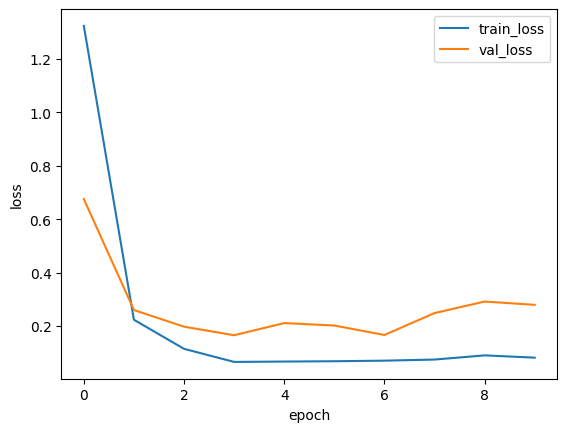

In [24]:
# loss_plot 텐서 리스트를 CPU로 옮기고 NumPy 배열로 변환
loss_plot_cpu = [x.detach().cpu().numpy() for x in loss_plot]

# 동일한 방법으로 val_loss_plot을 처리 (여기서는 val_loss_plot 예시가 제공되지 않았으므로 가정함)
val_loss_plot_cpu = [x.detach().cpu().numpy() for x in val_loss_plot]

# CPU 텐서를 사용하여 그래프를 그림
plt.plot(loss_plot_cpu, label='train_loss')
plt.plot(val_loss_plot_cpu, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [28]:
def predict(dataset):
    model.eval()
    tqdm_dataset = tqdm(enumerate(dataset))
    results = []
    for batch, batch_item in tqdm_dataset:
        img = batch_item['img'].to(device)
        seq = batch_item['csv_feature'].to(device)
        with torch.no_grad():
            output = model(img, seq)
        output = torch.tensor(torch.argmax(output, dim=1), dtype=torch.int32).cpu().numpy()
        results.extend(output)
    return results

model = CNN_Model(class_n)
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CNN_Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [ ]:
def Return_Deasea